In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('UNRATE.csv', header=None)
data.columns = ['Date','UNRATE']
data['Date']= pd.to_datetime(data['Date'], format='%d-%m-%Y')
data = data.set_index('Date')
data.head()

,UNRATE
Date,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5


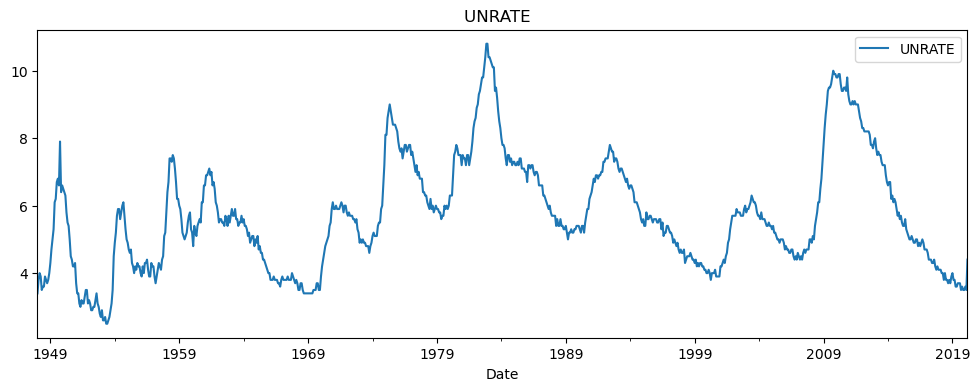

In [3]:
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('UNRATE  ')
plt.show(block=False)

In [4]:
data.isnull().sum()

UNRATE    0
dtype: int64

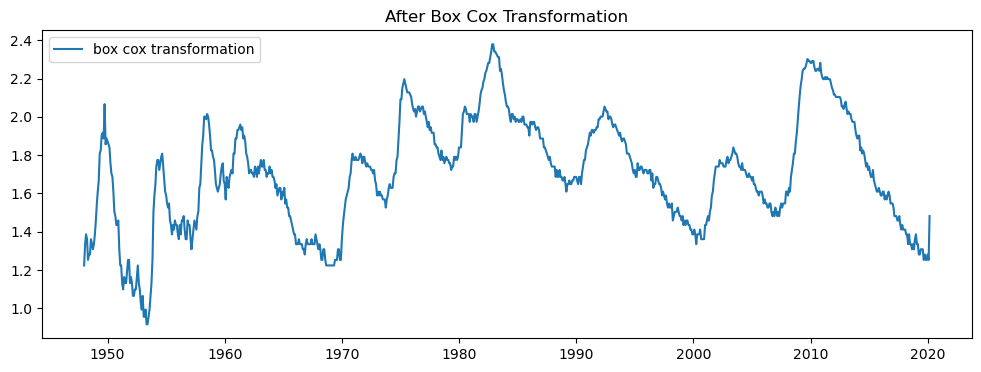

In [5]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data['UNRATE'], lmbda= 0), index= data.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label="box cox transformation")
plt.legend(loc='best')
plt.title('After Box Cox Transformation')
plt.show()

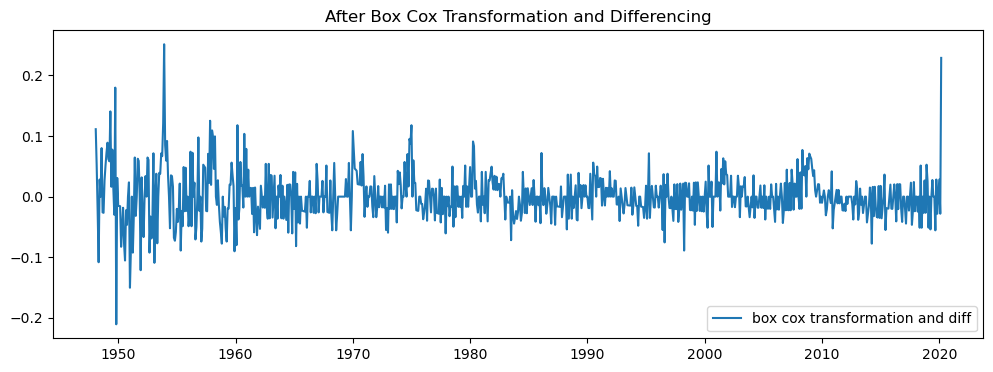

In [6]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), index= data.index)
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label="box cox transformation and diff")
plt.legend(loc='best')
plt.title('After Box Cox Transformation and Differencing')
plt.show()


In [7]:
train_len = 611
train = data[0:train_len] 
test = data[train_len:]

In [8]:
#train_len = 212
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1] 
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

In [9]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(12,0,0))
model_fit = model.fit()
print(model_fit.params)

/Users/iraiva/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/iraiva/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/iraiva/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


const     0.000437
ar.L1     0.061215
ar.L2     0.161310
ar.L3     0.118245
ar.L4     0.090530
ar.L5     0.106920
ar.L6     0.007965
ar.L7    -0.029404
ar.L8     0.033444
ar.L9     0.006010
ar.L10   -0.124809
ar.L11    0.047363
ar.L12   -0.148758
sigma2    0.001476
dtype: float64


In [10]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

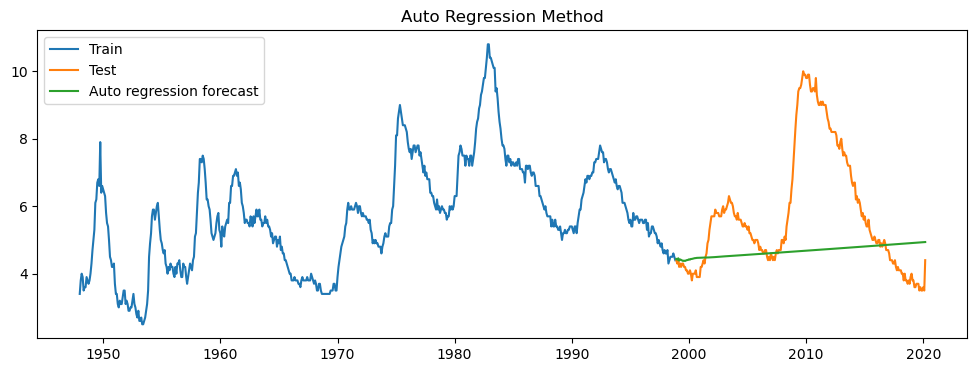

In [11]:
plt.figure(figsize=(12,4))
plt.plot(train['UNRATE'], label='Train')
plt.plot(test['UNRATE'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

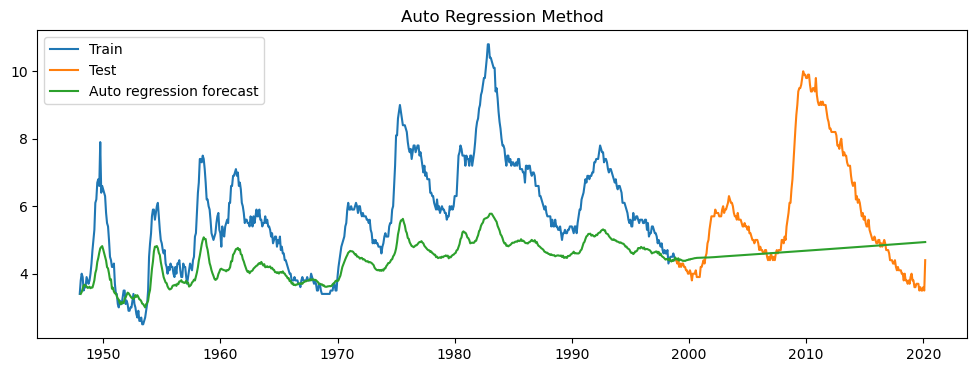

In [12]:
plt.figure(figsize=(12,4))
plt.plot(train['UNRATE'], label='Train')
plt.plot(test['UNRATE'], label='Test')
plt.plot(y_hat_ar['ar_forecast'], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

In [13]:
from sklearn.metrics import mean_squared_error


In [14]:
rmse = np.sqrt(mean_squared_error(test['UNRATE'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['UNRATE']-y_hat_ar['ar_forecast'][test.index.min():])/test['UNRATE'])*100,2)

Results = pd.DataFrame({'Method':['Autoregressive (AR) method'], 'RMSE': [rmse],'MAPE': [mape] })
Results = Results[['Method', 'RMSE', 'MAPE']]
Results

,Method,RMSE,MAPE
0,Autoregressive (AR) method,2.11,21.56


In [15]:
model = ARIMA(train_data_boxcox_diff, order=(0, 0, 5)) 
model_fit = model.fit()
print(model_fit.params)

/Users/iraiva/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/iraiva/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/iraiva/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


const     0.000495
ma.L1     0.055540
ma.L2     0.182161
ma.L3     0.123515
ma.L4     0.099724
ma.L5     0.151680
sigma2    0.001561
dtype: float64


In [16]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

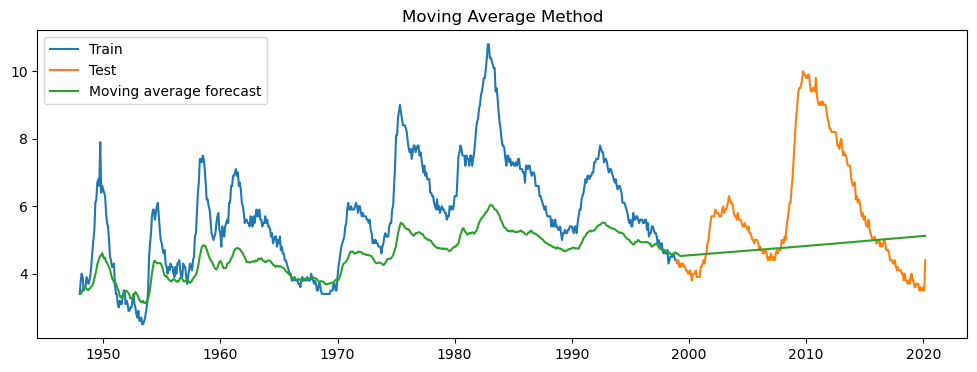

In [17]:
plt.figure(figsize=(12,4))
plt.plot(data['UNRATE'][:train_len], label='Train')
plt.plot(data['UNRATE'][train_len:], label='Test')
plt.plot(y_hat_ma['ma_forecast'], label='Moving average forecast')
plt.legend(loc='best')
plt.title('Moving Average Method')
plt.show()

In [18]:
rmse = np.sqrt(mean_squared_error(test['UNRATE'], y_hat_ma['ma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['UNRATE']-y_hat_ma['ma_forecast'][test.index.min():])/test['UNRATE'])*100,2)

tempResults = pd.DataFrame({'Method':['Moving Average (MA) method'], 'RMSE': [rmse],'MAPE': [mape] })
Results = pd.concat([Results, tempResults])
Results = Results[['Method', 'RMSE', 'MAPE']]
Results


,Method,RMSE,MAPE
0,Autoregressive (AR) method,2.11,21.56
0,Moving Average (MA) method,2.04,21.49


In [19]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(12,1,5))
model_fit = model.fit()
print(model_fit.params)

/Users/iraiva/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/iraiva/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/iraiva/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ar.L1    -0.539295
ar.L2    -0.239327
ar.L3    -0.015004
ar.L4     0.143367
ar.L5     0.274161
ar.L6     0.113488
ar.L7     0.000456
ar.L8     0.020900
ar.L9     0.007987
ar.L10   -0.097424
ar.L11    0.042967
ar.L12   -0.051653
ma.L1    -0.339610
ma.L2    -0.141119
ma.L3    -0.160257
ma.L4    -0.123252
ma.L5    -0.157064
sigma2    0.001526
dtype: float64


/Users/iraiva/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

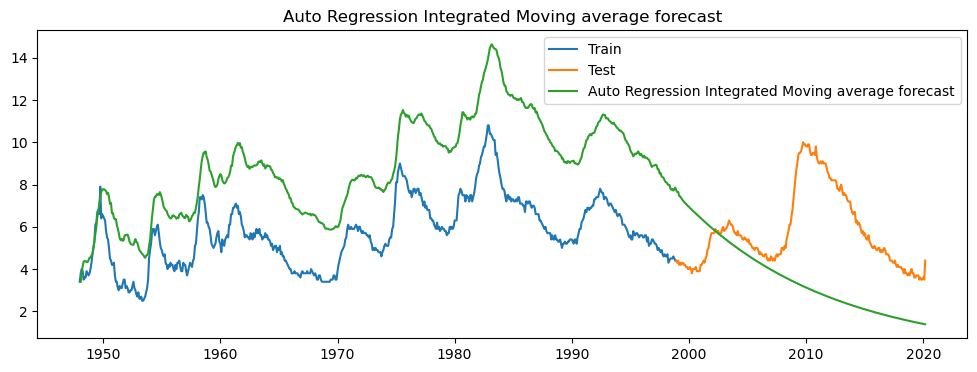

In [21]:
plt.figure(figsize=(12,4))
plt.plot(data['UNRATE'][:train_len], label='Train')
plt.plot(data['UNRATE'][train_len:], label='Test')
plt.plot(y_hat_arima['arima_forecast'], label='Auto Regression Integrated Moving average forecast')
plt.legend(loc='best')
plt.title('Auto Regression Integrated Moving average forecast')
plt.show()

In [22]:
rmse = np.sqrt(mean_squared_error(test['UNRATE'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['UNRATE']-y_hat_arima['arima_forecast'][test.index.min():])/test['UNRATE'])*100,2)

tempResults = pd.DataFrame({'Method':['Auto Regression Integrated Moving Average (ARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
Results = pd.concat([Results, tempResults])
Results = Results[['Method', 'RMSE', 'MAPE']]
Results

,Method,RMSE,MAPE
0,Autoregressive (AR) method,2.11,21.56
0,Moving Average (MA) method,2.04,21.49
0,Auto Regression Integrated Moving Average (ARI...,3.46,47.08


In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train_data_boxcox, order=(2,1,4), seasonal_order=(2,1,4,12))
model_fit = model.fit()
print(model_fit.params)


/Users/iraiva/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/iraiva/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.62916D+00    |proj g|=  8.49638D+00


 This problem is unconstrained.



At iterate    5    f= -1.72920D+00    |proj g|=  2.78903D+00

At iterate   10    f= -1.74342D+00    |proj g|=  5.08078D-01

At iterate   15    f= -1.74868D+00    |proj g|=  1.74793D+00

At iterate   20    f= -1.75104D+00    |proj g|=  2.23267D-01

At iterate   25    f= -1.75218D+00    |proj g|=  8.43614D-02

At iterate   30    f= -1.75372D+00    |proj g|=  5.95344D-02

At iterate   35    f= -1.75512D+00    |proj g|=  1.45332D-01

At iterate   40    f= -1.75641D+00    |proj g|=  2.42601D-02

At iterate   45    f= -1.75684D+00    |proj g|=  5.52723D-02


/Users/iraiva/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -1.75740D+00    |proj g|=  1.83583D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     63      1     0     0   1.836D-02  -1.757D+00
  F =  -1.7573965018471902     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ar.L1       0.587782
ar.L2       0.140660
ma.L1      -0.566433
ma.L2       0.002815
ma.L3       0.058888
ma.L4       0.045194
ar.S.L12   -0.919506
ar.S.L24   -0.504757
ma.S.L12   -0.287503
ma.S.L24   -0.513580
ma.S.L36   -0.400495
ma.S.L48    0.257173
sigma2      0.001498
dtype: float64


In [24]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

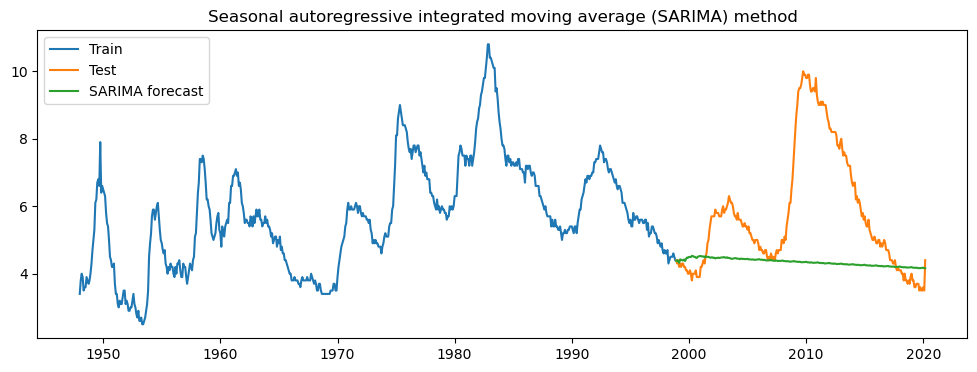

In [25]:
plt.figure(figsize=(12,4))
plt.plot(train['UNRATE'], label='Train')
plt.plot(test['UNRATE'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

In [26]:
rmse = np.sqrt(mean_squared_error(test['UNRATE'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['UNRATE']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['UNRATE'])*100,2)

tempResults = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
Results = pd.concat([Results, tempResults])
Results = Results[['Method', 'RMSE', 'MAPE']]
Results


,Method,RMSE,MAPE
0,Autoregressive (AR) method,2.11,21.56
0,Moving Average (MA) method,2.04,21.49
0,Auto Regression Integrated Moving Average (ARI...,3.46,47.08
0,Seasonal autoregressive integrated moving aver...,2.30,22.53
